In [1]:
import pathlib
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
import numpy as np
import pickle
from itertools import islice
import gzip
from prompter import Prompter

In [36]:
import chromadb
"""
from ollama import Client  # type: ignore
"""
from chromadb.utils.embedding_functions import OllamaEmbeddingFunction

In [37]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [38]:
"""
ollama_client = Client(
    host='http://kumo01.tsc.uc3m.es:11434',
    headers={'x-some-header': 'some-value'}
)
"""

"\nollama_client = Client(\n    host='http://kumo01.tsc.uc3m.es:11434',\n    headers={'x-some-header': 'some-value'}\n)\n"

In [39]:
llm_model_embeddings = 'mxbai-embed-large'

In [40]:
def get_doc_top_tpcs(doc_distr, topn=2):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:topn].tolist()
    top_weight = [(k, doc_distr[k]) for k in top]
    return top_weight

def get_doc_main_topc(doc_distr):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:1][0]
    return top

In [41]:
path_source = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/source/corpus_rosie/passages/multi_blade_filtered_v2/df_1.parquet")
path_model = pathlib.Path(
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/models/MULTI_BLADE_FILTERED_v2/poly_rosie_1_100")

In [42]:
raw = pd.read_parquet(path_source)
thetas = sparse.load_npz(path_model / "mallet_output" / "thetas_EN.npz")
raw["thetas"] = list(thetas.toarray())
raw.loc[:, "top_k"] = raw["thetas"].apply(get_doc_top_tpcs)
raw.loc[:, "main_topic"] = raw["thetas"].apply(get_doc_main_topc)

In [43]:
with open(path_model / "mallet_output" / "keys_EN.txt", 'r') as file:
    lines = file.readlines()
topic_keys = [line.strip() for line in lines]
for i, key in enumerate(topic_keys):
    print(i, key)

0 technology fluid body temperature heat liquid store cold day drink solution hour child container water dehydration hot degree medication
1 patient study clinical trial evaluate outcome control evidence result purpose criterion cohort finding follow researcher assess efficacy determine observe
2 bone joint foot leg fracture technology knee arm hip muscle shoulder hand pain finger tendon position ankle tissue ligament
3 question prepare procedure answer follow list time appointment write treatment child expect doctor technology visit instruction condition provider recommend
4 baby infant milk technology breastfeed bear newborn breast mother birth feed month time feeding week organization formula premature breastfeeding
5 suicide health violence abuse youth experience death organization behavior sexual include prevention homicide partner crisis physical prevent adult person
6 tuberculosis hepatitis infection person patient contact transmission health organization hcv facility hbv contro

In [44]:
# Separate English and Spanish documents
df_en = raw[raw['doc_id'].str.startswith("EN")].copy()
df_es = raw[raw['doc_id'].str.startswith("ES")].copy()

In [45]:
len(df_es)

917137

In [46]:
# Keep one topic for each corpus
tpc = 12
df_en_tpc = df_en[df_en.main_topic == tpc].copy().iloc[:100]
df_es_tpc = df_es[df_es.main_topic == tpc].copy().iloc[:100]

In [47]:
df_es_tpc.iloc[0].common_id

1393751

In [48]:
df_es_tpc.iloc[0].text

'Perform a new searcheditar los filtros de búsqueda cerca Limita tu búsqueda Por afecciones tratadas/procedimientos realizados No se encontraron resultados. Por ubicación Rochester, MN Jacksonville, FL Phoenix/Scottsdale, AZ Por apellido Buscar un médico cuyo apellido comience con una letra A A Buscar un médico cuyo apellido comience con una letra B B Buscar un médico cuyo apellido comience con una letra C C Buscar un médico cuyo apellido comience con una letra D D Buscar un médico cuyo apellido comience con una letra E E Buscar un médico cuyo apellido comience con una letra F F Buscar un médico cuyo apellido comience con una letra G G Buscar un médico cuyo apellido comience con una letra H H Buscar un médico cuyo apellido comience con una letra I I Buscar un médico cuyo apellido comience con una letra J J Buscar un médico cuyo apellido comience con una letra K K activo Buscar un médico cuyo apellido comience con una letra L L Buscar un médico cuyo apellido comience con una letra M M B

In [51]:
df_en.columns

Index(['id_top', 'doc_id', 'id_preproc', 'document_id', 'text', 'len',
       'full_doc', 'human_labeled', 'lemmas', 'lemmas_tr', 'text_tr', 'lang',
       'final_label', 'common_id', 'thetas', 'top_k', 'main_topic'],
      dtype='object')

In [88]:
df_en.iloc[20].text

'At foam parties, soapy foam is sprayed onto the dance floor while participants dance. The foam is distributed from blowers on the ground or attached to the ceiling, and several feet of foam can accumulate. Foam parties can last for several hours while foam is dispersed intermittently throughout the night. Products used at these events to produce foam contain ingredients similar to those in soaps and shampoos, such as sodium lauryl sulfate. Some formulations used at foam parties are proprietary, and chemicals, chemical compositions, and concentrations are unknown. For use at a foam party, the product is purchased in a highly concentrated form and diluted with water before use. This was the third foam party of the year at this nightclub.'

In [100]:
template_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/templates/1_instruction_prompt.txt"
system_template_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/templates/1_system_prompt.txt"
llm_model = "llama3.1:8b-instruct-q8_0"
with open(template_path, 'r') as file:
    template = file.read()

In [101]:
question = template.format(passage=df_en.iloc[20].text, full_document=df_en.iloc[20].full_doc)
print(question)

Create YES/NO questions based on the provided PASSAGE. These questions should be explicitly tied to the information in the PASSAGE and should not require additional context from the FULL_DOCUMENT or external knowledge.

### Guidelines:
1. Use the FULL_DOCUMENT only to understand the broader context of the PASSAGE. Do not directly use information from the FULL_DOCUMENT in your questions.
2. Each question must be self-contained, providing all necessary details within the question itself.
3. Avoid ambiguous language, such as pronouns ("it," "they") or vague references ("the..."), unless explicitly clarified in the question.
4. Ensure clarity and precision by explicitly naming the object or process in question, even if repetition is required.
5. Each question should focus on a single, clear point.

### Example:
PASSAGE: Removing the catheter:\n- In the morning, remove the catheter.\n- First, take the water out of the balloon. Place a syringe on the colored balloon port and let the water fi

In [102]:
prompter = Prompter(
    model_type=llm_model,
)

questions, _ = prompter.prompt(
    system_prompt_template_path=system_template_path,
    question=question
)

Cache miss: computing results...


In [103]:
questions

'--- Is foam sprayed onto the dance floor at a foam party while participants are dancing? \n--- Are blowers used to distribute foam from the ground or ceiling during a foam party? \n--- Can several feet of foam accumulate on the dance floor during a foam party? \n--- Do products used to produce foam at foam parties contain ingredients similar to those in soaps and shampoos? \n--- Is sodium lauryl sulfate an ingredient found in some formulations used at foam parties? \n--- Are some formulations used at foam parties proprietary, meaning their chemical compositions and concentrations are unknown? \n--- Is the product used to produce foam purchased in a highly concentrated form before being diluted with water for use at a foam party?'

In [49]:
mallet_out_folder = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/models/29_dec/all/poly_rosie_1_20/mallet_output"
mallet_out_folder = pathlib.Path(mallet_out_folder)

In [50]:
topic_state_model = mallet_out_folder / "output-state.gz"
with gzip.open(topic_state_model) as fin:
    topic_state_df = pd.read_csv(
        fin, delim_whitespace=True,
        names=['docid', 'lang', 'wd_docid','wd_vocabid', 'wd', 'tpc'],
        header=None, skiprows=1)

/tmp/ipykernel_2976815/2165744603.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  topic_state_df = pd.read_csv(


In [51]:
betas_dict = {}
for lang, id_lang in [("EN", 0), ("ES", 1)]:
    
    print(f"-- -- Executing for {lang}")
    # Filter by lang
    df_lang = topic_state_df[topic_state_df.lang == id_lang]
    
    vocab_size = len(df_lang.wd_vocabid.unique())
    num_topics = len(df_lang.tpc.unique())
    betas = np.zeros((num_topics, vocab_size))
    vocab = list(df_lang.wd.unique())
    term_freq = np.zeros((vocab_size,))
    
    # Group by 'tpc' and 'wd_vocabid', and count occurrences
    grouped = df_lang.groupby(['tpc', 'wd_vocabid']).size().reset_index(name='count')

    # Populate the betas matrix with the counts
    for _, row in grouped.iterrows():
        tpc = row['tpc']
        vocab_id = row['wd_vocabid']
        count = row['count']
        betas[tpc, vocab_id] = count
        term_freq[vocab_id] += count
    betas = normalize(betas, axis=1, norm='l1')
    
    betas_dict[lang] = betas
        
    vocab_file = mallet_out_folder / f"vocab_{lang}.txt"
    betas_file = mallet_out_folder / f"betas_{lang}.npy"
    with vocab_file.open('w', encoding='utf8') as fout:
        for el in zip(vocab, term_freq):
            term = str(el[0])
            try:
                freq = int(float(el[1]))  # Convert to float first, then int
                fout.write(f"{term}\t{freq}\n")
            except (ValueError, TypeError):
                print(f"Skipping invalid term_freq value: {el[1]}")
    np.save(betas_file, betas)

-- -- Executing for EN
-- -- Executing for ES


In [52]:
topic_keys = mallet_out_folder / "topickeys.txt"
topic_keys_df = pd.read_csv(
    topic_keys, delimiter="\t", 
    names = ['lang', 'langTokensPerTopic', 'betas', 'topK'],
    header=None
).dropna()

for lang, id_lang in [("EN", 0), ("ES", 1)]:
    # Filter by lang
    df_lang = topic_keys_df[topic_keys_df.lang == id_lang]
    
    keys_file = mallet_out_folder / f"keys_{lang}.txt"
    with open(keys_file, 'w') as file:
        # Iterate over each value in the column and write it to the file
        for value in df_lang["topK"]:
            file.write(str(value) + '\n')

In [53]:
lang1_thetas = sparse.load_npz(mallet_out_folder / "thetas_EN.npz")
lang2_thetas = sparse.load_npz(mallet_out_folder / "thetas_ES.npz")

thetas_dict = {
    "EN": lang1_thetas,
    "ES": lang2_thetas
}

In [64]:
df = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/source/corpus_rosie/passages/29_dec/all/df_1.parquet")
docs_lang = {}
lang_lengths = {}
for lang in ["EN", "ES"]:
    df_lang = df.copy()
    
    docs_lang[lang] = df_lang[df_lang["lang"] == lang]
    lang_lengths[lang] = len(docs_lang[lang])

In [65]:
for lang, id_lang in [("EN", 0), ("ES", 1)]:

    thetas = thetas_dict[lang].toarray()
    betas = betas_dict[lang]
    documents_texts = docs_lang[lang]["lemmas"].apply(lambda x: x.split()).tolist()
    
    vocab_w2id = {}
    vocab_id2w = {}
    with open(mallet_out_folder / f"vocab_{lang}.txt") as file:
        for i, line in enumerate(file):
            # Strip leading and trailing whitespace
            stripped_line = line.strip()
            # Split the line into words and numbers
            parts = stripped_line.split()
            if parts:
                # Get the word (first part)
                wd = parts[0]
                # Populate the dictionaries
                vocab_w2id[wd] = i
                vocab_id2w[str(i)] = wd
                
    D = len(thetas)
    K = len(betas)
    S3 = np.zeros((D, K))

    for doc in range(D):
        for topic in range(K):
            wd_ids = [vocab_w2id[word]
                    for word in documents_texts[doc] if word in vocab_w2id]
            S3[doc, topic] = np.sum(betas[topic, wd_ids]) * (1 / len(documents_texts[doc]))
    
    S3 = sparse.csr_matrix(S3, copy=True)
            
    s3_file = mallet_out_folder / f"s3_{lang}.npz"
    sparse.save_npz(s3_file, S3)

In [66]:
import sys
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
from kneed import KneeLocator
from scipy.ndimage import uniform_filter1d
from scipy import sparse

In [67]:
topic_keys = mallet_out_folder / "topickeys.txt"
topic_keys_df = pd.read_csv(
    topic_keys, delimiter="\t", 
    names = ['lang', 'langTokensPerTopic', 'betas', 'topK'],
    header=None
).dropna()

for lang, id_lang in [("EN", 0), ("ES", 1)]:
    # Filter by lang
    df_lang = topic_keys_df[topic_keys_df.lang == id_lang]
    
    keys_file = mallet_out_folder / f"keys_{lang}.txt"
    with open(keys_file, 'w') as file:
        # Iterate over each value in the column and write it to the file
        for value in df_lang["topK"]:
            file.write(str(value) + '\n')

topics_keys = df_lang.topK.values.tolist()
topics = [16,14,8,3]
kept_topics = [" ".join(topics_keys[i].split()[:4]) for i in topics]
print(kept_topics)

['diabetes sangre actividad enfermedad', 'persona riesgo trastorno salud', 'síntoma dolor piel causar', 'salud departamento nacional centro']


In [68]:
thetas32 = thetas_dict["ES"].toarray()
thetas32[topics]

array([[0.04347826, 0.        , 0.        , 0.        , 0.        ,
        0.04347826, 0.86956521, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04347826, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.        , 0.04545455, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.13636364, 0.        , 0.        , 0.77272726, 0.        ],
       [0.        , 0.        , 0.        , 0.14457831, 0.01204819,
        0.02409638, 0.        , 0.3493976 , 0.        , 0.01204819,
        0.        , 0.01204819, 0.        , 0.13253012, 0.01204819,
        0.01204819, 0.18072289, 0.03614458, 0.01204819, 0.06024097],
       [0.        , 0.        , 0.40000001, 0.        , 0.        ,
        0.        , 0.24      , 0.        , 0.08      , 0.        ,
        0.        , 0.04      , 0.12      , 0

In [69]:
def thrFig(
        thetas32,
        topics=None,
        max_docs=1000,
        poly_degree=3,
        smoothing_window=5,
        do_knee=True,
        n_steps=1000,
        figsize=(10, 6),
        fontsize=12,
        output_fpath=None,
    ):
    significant_docs = {}
    all_elbows = []
    
    # use colorbrewer Set2 colors
    colors = plt.cm.Dark2(np.linspace(0, 1, thetas32.shape[1]))
    n_docs = thetas32.shape[0]
    print(max_docs)
    max_docs = n_docs
    plt.figure(figsize=figsize)

    lines = []
    for k in range(len(thetas32.T)):
        theta_k = np.sort(thetas32[:, k])
        theta_over_th = theta_k[-max_docs:]
        step = max(1, int(np.round(len(theta_over_th) / n_steps)))
        y_values = theta_over_th[::step]
        x_values = np.arange(n_docs-max_docs, n_docs)[::step]

        # Apply smoothing
        x_values_smooth = uniform_filter1d(x_values, size=smoothing_window)

        label = None
        if topics is not None:
            label = topics[k]
        line, = plt.plot(x_values_smooth, y_values, color=colors[k], label=label)
        lines.append(line)
        
        if do_knee:
            # Using KneeLocator to find the elbow point
            allvalues = np.sort(thetas32[:, k].flatten())
            step = int(np.round(len(allvalues) / 1000))
            theta_values = allvalues[::step]
            idx_values = (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step]
            
            # Apply smoothing
            idx_values_smooth = uniform_filter1d(idx_values, size=smoothing_window)

            kneedle = KneeLocator(theta_values, idx_values_smooth, curve='concave', direction='increasing', interp_method='polynomial', polynomial_degree=poly_degree)
            elbow = kneedle.elbow
            if elbow is not None:
                all_elbows.append(elbow)

                # Filter document indices based on the elbow point (keeping values above the elbow)
                significant_docs[k] = np.where(thetas32[:, k] >= elbow)[0]

        if elbow:
            # plot elbow in same color, smaller linewidth
            plt.plot([n_docs - max_docs, n_docs], [elbow, elbow], color=colors[k], linestyle='--', linewidth=1)

    # add legend where this series is named with the kth topic, do not assign to the 
    # elbow line
    if topics is not None:
        plt.legend(handles=lines, loc='upper left', fontsize=fontsize-1)

    # Add axis labels
    plt.xlabel('Document Index', fontsize=fontsize)
    plt.ylabel('Theta — P(k | d)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if output_fpath:
        # make bounding box extremely tight
        plt.savefig(output_fpath, bbox_inches='tight', pad_inches=0)

    plt.show()

    return significant_docs, all_elbows


1000


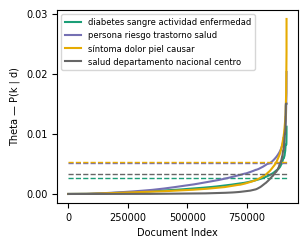

In [70]:
significant_docs, elbows = thrFig(
    (S3.toarray())[:, topics],
    topics=kept_topics,
    max_docs=1000,
    do_knee=True,
    n_steps=5_000,
    figsize=(3.1, 2.5),
    fontsize=7,
    #output_fpath="../figures/thetas_mallet.pdf",
)

In [71]:
thetas32

array([[0.        , 0.        , 0.53333335, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00970874, ..., 0.00970874, 0.00970874,
        0.        ],
       [0.        , 0.88888889, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02222222, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05      ,
        0.        ],
       [0.01219512, 0.        , 0.01219512, ..., 0.        , 0.01219512,
        0.        ]])